# Applied Seismology, GEOS 626/426, University of Alaska Fairbanks
# Inverse Problems and Parameter Estimation, GEOS 627/427, University of Alaska Fairbanks

- script lab_linefit.ipynb
- this program introduces the least squares method for the example of fitting a line (i.e., a model with two
 parameters) to a set of scattered data
- three options for solving the problem are shown, each of which gives the same result
- no regularization is needed (or used) in this example

In [27]:
%matplotlib inline

In [28]:
import warnings

import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import scipy.linalg as la
from sympy.matrices import Matrix

In [29]:
# script settings

warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = 8, 10

In [30]:
# Variable initialization and user flags

# USER PARAMETERS (CHANGE THESE)
ndata = 50                             # number of observations
sigma = 0.3                            # standard deviations of added errors

# TARGET model vector (m1=y-intercept, m2=slope)
mtar = np.array([[2.1], [-0.5]])
nparm = len(mtar)                      # number of model parameters

Matrix(mtar)

Matrix([
[ 2.1],
[-0.5]])

In [31]:
# compute design matrix
# x is a vector of x_i locations where your measurements y_i will be made
xmin = -2
xmax = 2
x = np.linspace(xmin,xmax,ndata)       # input x-values
x = np.reshape(x,(ndata,1))
G = np.hstack((np.ones((ndata,1)),x))  # ndata by nparm design matrix
#Matrix(G)

In [32]:
%whos int ndarray

Variable   Type       Data/Info
-------------------------------
G          ndarray    50x2: 100 elems, type `float64`, 800 bytes
M1         ndarray    100x100: 10000 elems, type `float64`, 80000 bytes
M2         ndarray    100x100: 10000 elems, type `float64`, 80000 bytes
Nh         ndarray    19: 19 elems, type `int64`, 152 bytes
RSSm       ndarray    10000x1: 10000 elems, type `float64`, 80000 bytes
Z          ndarray    100x100: 10000 elems, type `float64`, 80000 bytes
a          int        100
b          int        100
bins       ndarray    20: 20 elems, type `float64`, 160 bytes
d          ndarray    50000x1: 50000 elems, type `float64`, 400000 bytes (390.625 kb)
dobs       ndarray    50000x1: 50000 elems, type `float64`, 400000 bytes (390.625 kb)
dtar       ndarray    50000x1: 50000 elems, type `float64`, 400000 bytes (390.625 kb)
dtry       ndarray    50000x1: 50000 elems, type `float64`, 400000 bytes (390.625 kb)
e          ndarray    50000x1: 50000 elems, type `float64`, 40000

In [33]:
# generate errors
e = sigma * np.random.randn(ndata,1)   # normally distributed random numbers

# generate target 'data' with errors added
dtar = G@mtar
dobs = dtar + e

# optional: add one big anomaly
#dobs[0] = dobs[0] + 1000*sigma

In [34]:
# SOLVE: compute least squares solution, estimates, and estimated variance.
# (We show three options for mest, each with the same result.)
x_temp = x.flatten()                    # polyfit does not accomodate an (ndata,1) array, so we flatten it to (ndata,)
temp = np.polyfit(x_temp,dobs,1)        # temp has shape (2,1)
mest = np.flipud(temp)                  # polyfit returns [slope,intercept] but we want the order to be [intercept,slope]
Matrix(mest)

Matrix([
[   2.1100305360399],
[-0.574407957823739]])

In [35]:
mest = la.inv(G.T@G)@G.T@dobs
Matrix(mest)

Matrix([
[   2.1100305360399],
[-0.574407957823738]])

In [36]:
mest = la.pinv(G)@dobs
Matrix(mest)

Matrix([
[   2.1100305360399],
[-0.574407957823739]])

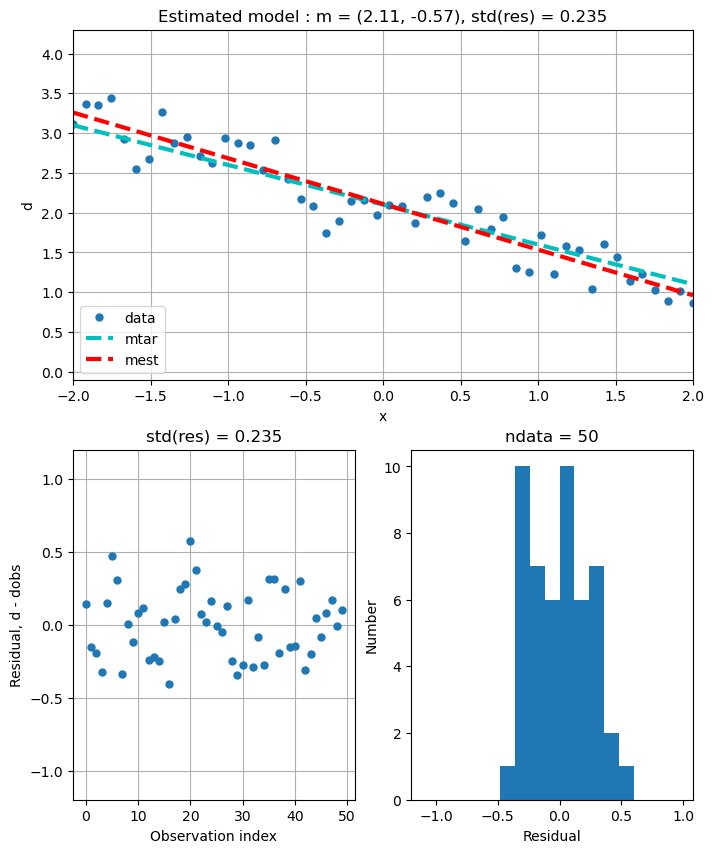

In [37]:
d = G@mest             # estimated predictions
res = d - dobs         # residuals

stres = 'std(res) = %.3f'% (np.std(res))

gs = gridspec.GridSpec(2, 2)
fig = plt.figure(num=1)
ax = fig.add_subplot(gs[0, :]) # row 0, span both columns
ymx = 4*sigma  # variable for axis limits

title = 'Estimated model : m = (%.2f, %.2f)'% (mest[0],mest[1]) + ', ' + stres
#ax.plot(x,G*mtar,'k--',lw=2)
ax.plot(x,dobs,'.',ms=10,label='data')
ax.plot(x,dtar,'c--',lw=3,label='mtar')
ax.plot(x,d,'r--',lw=3,label='mest')
ax.legend(loc='lower left')
ax.set(xlabel='x', ylabel='d', title=title)
ax.axis([min(x), max(x), min(G@mtar)-ymx, max(G@mtar)+ymx])
ax.grid()

ax = fig.add_subplot(gs[1, 0]) # row 1, col 0
ax.plot(res,'.',ms=10)
ax.set(xlabel='Observation index', ylabel='Residual, d - dobs', title=stres)
ax.set(ylim=(-ymx,ymx))
ax.grid()

ax = fig.add_subplot(gs[1, 1]) # row 1, col 1
edges = np.arange(-ymx,ymx,ymx/10)
Nh, bins = np.histogram(res,edges)
    
title = 'ndata = %i'% (ndata)
ax.hist(edges[:-1],edges,weights=Nh)
ax.set(xlabel='Residual', ylabel='Number', title=title, xlim=[min(edges), max(edges)])

plt.show()

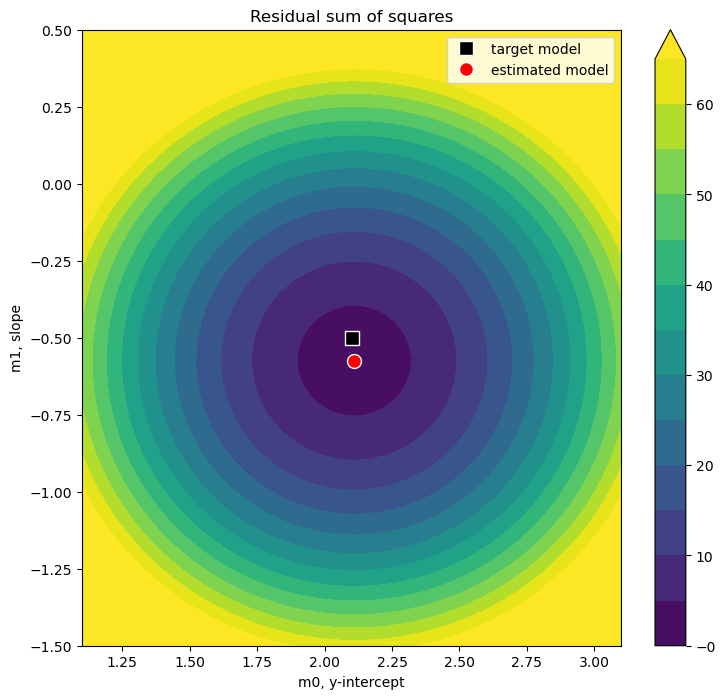

In [38]:
# generate a plot showing the residual sum of squares (RSS) as a function of model space

# search range, measured by the distance from the target model
m1_ran = 1
m2_ran = 1

# number controlling the number of gridpoints in model space
nx = 100   # for the misfit function plot
#nx = 10   # for the gradient plot (fewer arrows)

# generate grid for the model space
m1_vec = np.linspace(mtar[0]-m1_ran, mtar[0]+m1_ran, nx)
m2_vec = np.linspace(mtar[1]-m2_ran, mtar[1]+m2_ran, nx)
    
M1, M2 = np.meshgrid(m1_vec, m2_vec)
a, b = M1.shape
    
ngrid = a*b   # number of gridpoints in model space
    
m1 = np.reshape(M1,(1,ngrid))
m2 = np.reshape(M2,(1,ngrid))

# compute misfit function (and gradient)
RSSm = np.zeros((ngrid,1))                 # initialize misfit function
# INITIALIZE GRADIENT HERE
gammam = np.zeros((2,ngrid))

for pp in range(ngrid):
    mtry = np.array([m1[0,pp], m2[0,pp]])  # a sample from model space
    mtry = np.reshape(mtry,(2,1))
    dtry = G@mtry                          # predictions from the model
    res = dtry - dobs                      # residuals between predictions and data
    RSS = np.sum(res*res)                  # residual sum of squares
    RSSm[pp,0] = RSS                       # pp entry of ngrid x 1 vector RSSm
    
    # COMPUTE GRADIENT HERE [DO NOT USE NUMPY'S gradient FUNCTION]
    G.T@res
    gammam
    
    
Z = np.reshape(RSSm,(a,b))           # reshape for plotting
    
# plot the misfit function
levels = np.arange(-1e-6, 0.5*max(RSSm),step=5)

plt.figure(figsize=(8.7,8))
plt.contourf(M1,M2,Z,levels,extend='max')
#plt.pcolor(M1,M2,np.reshape(RSSm,(a,b)))
#plt.scatter(m1,m2,s=6^2,c=RSSm)
plt.plot(mtar[0],mtar[1],'ws',ms=10,mfc='k',label='target model')
plt.plot(mest[0],mest[1],'wo',ms=10,mfc='r',label='estimated model')
plt.legend(loc='upper right')
plt.colorbar()
plt.xlabel('m0, y-intercept')
plt.ylabel('m1, slope')
plt.title('Residual sum of squares')
plt.axis('equal')
plt.axis('tight')
plt.show()

In [39]:
#  PLOT GRADIENT HERE WITH matplotlib quiver COMMAND 

